<a href="https://colab.research.google.com/github/DavidMihalcea880/GDP2023/blob/Maisy/yollo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/WongKinYiu/yolov7.git


Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.93 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (522/522), done.


In [2]:
%cd yolov7

/content/yolov7


In [3]:
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7-w6-pose.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M  100  153M    0     0  13.3M      0  0:00:11  0:00:11 --:--:-- 7077k


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00


In [69]:
import torch
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts,plot_one_box
from utils.torch_utils import select_device
from models.experimental import attempt_load

import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
%matplotlib inline

In [70]:
def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()
    if torch.cuda.is_available():
      # half() turns predictions into float16 tensors
      # which significantly lowers inference time
      model.half().to(device)
    return model

model = load_model()

In [71]:
@torch.no_grad()
def run_inference(url):
    image = cv2.imread(url) 
    # Resize and pad image
    image = letterbox(image, 640, stride=64, auto=True)[0] 
    # Apply transforms
    image = transforms.ToTensor()(image) 
    image = image.type(torch.cuda.HalfTensor)
    # Turn image into batch
    image = image.unsqueeze(0) 
    output, _ = model(image) 
    return output, image

In [87]:
@torch.no_grad()
def visualize_output(output, image):
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(nimg)
    plt.show()
    return nimg,output

In [9]:
@torch.no_grad()
def video_output(frame):
    image = frame
    # Resize and pad image
    image = letterbox(image, 640, stride=64, auto=True)[0] 
    # Apply transforms
    image = transforms.ToTensor()(image) 
    #image = image.type(torch.cuda.HalfTensor)
    # Turn image into batch
    image = image.unsqueeze(0) 
    output, _ = model(image)
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    return nimg,output

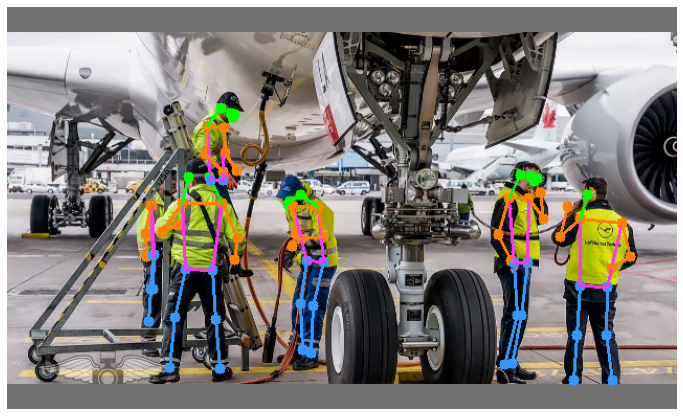

In [123]:
output, image=run_inference('creww.jpg')
_,output = visualize_output(output, image)

In [168]:
print(output[1,:])
print(output.shape)

[          0           0      561.69      260.03       83.75      198.75     0.92722         551      182.62    0.096558         551       178.5     0.16089         552      178.62    0.012527       554.5      179.25     0.93604         573      179.25     0.47461         547      202.12     0.97314         587
       206.5     0.97217       528.5         219     0.89844         595      238.38     0.87842       535.5      190.25     0.75098         577      249.38     0.72559         547       266.5     0.97754       573.5      267.75     0.97656       544.5       313.5     0.93457         572      313.75     0.93115
         541      356.75     0.82275       578.5       356.5     0.81982]
(6, 58)


The number of rows correspon to the number of human pose detected. we have 6 people so the output shape is [6,58]
as for the colomn (what does the 58 numer means) 
th first 7 is idx [batch_id, class_id, x, y, w, h, conf], we don't have a bath or class, so it is zero. Then the next 4 is the bboundingg box xcentre ycentre width and height. and finally confident score.

then the rest [7:58] is the x_cord, y_cord, confident score of skeleton point. 

First 5 points are faces [7:22]\
then shoulder [22:28]\
arms[28:40]\
legs[40:58]\

left right left right top to bottom

In [176]:
steps=3
idx=1
kpt= output[idx,7:22]
num_kpts = len(kpt) // steps
fig, ax = plt.subplots(figsize=(12, 9))
for i in range(num_kpts):
  x_coord, y_coord = kpt[steps*i], kpt[steps * i+ 1]
  conf = kpt[steps * i + 2]
  #if conf < 0.5:
    #continue
  ax.plot(x_coord, y_coord,'ro')
plt.xlim([0, 640])
plt.ylim([0, 480])

In [188]:
idx=1
kpt= output[idx,7:]
num_kpts = len(kpt) // steps
kpt.reshape(num_kpts, 3)

array([[        551,      182.62,    0.096558],
       [        551,       178.5,     0.16089],
       [        552,      178.62,    0.012527],
       [      554.5,      179.25,     0.93604],
       [        573,      179.25,     0.47461],
       [        547,      202.12,     0.97314],
       [        587,       206.5,     0.97217],
       [      528.5,         219,     0.89844],
       [        595,      238.38,     0.87842],
       [      535.5,      190.25,     0.75098],
       [        577,      249.38,     0.72559],
       [        547,       266.5,     0.97754],
       [      573.5,      267.75,     0.97656],
       [      544.5,       313.5,     0.93457],
       [        572,      313.75,     0.93115],
       [        541,      356.75,     0.82275],
       [      578.5,       356.5,     0.81982]])

# colab webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
  # function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img
  # function to convert OpenCV  bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing skeleton to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
#initiaize fps count
frame_count, total_fps = 0, 0
while True:
    start_time = time.time()
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    nimg,output=video_output(frame)
    cv2_imshow(nimg)
    end_time = time.time()
    fps = 1 / (end_time - start_time)
    total_fps += fps
    frame_count += 1
    '''
    for idx in range(output.shape[0]):
          plot_skeleton_kpts(bbox_array, output[idx, 7:].T, 3)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    '''
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")